# Analyze cell state dynamics batched experimental conditions
In this tutorial, we will show how to analyze the effect of batched experimental conditions using exdyn. We will apply exdyn to simulated data set where cluster 0 population differentiate into cluster 1 in condition 1 and cluster 2 in condition 2.


## Model set up and optimization
Exdyn accepts AnnData object for dynamics estimation. The model parameters such as the number of neural network layers can be specified through a dictionary of the parameters.

In [32]:
import scanpy as sc
# from exdyn import workflow, visualization
from src import workflow, visualization, condiff, modules, commons
import random
import numpy as np
import torch

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

orig_adata = sc.read_h5ad('data/sim_adata_mod.h5ad')
model_params = {
            'z_dim': 10,
            'enc_z_h_dim': 50, 'enc_d_h_dim': 50, 'dec_z_h_dim': 50,
            'num_enc_z_layers': 2, 'num_enc_d_layers': 2,
            'num_dec_z_layers': 2, 'use_ambient': False, 'use_vamp': False, 'no_d_kld': False, 'decreasing_temp': False, 'dec_temp_steps': 30000, 'loss_mode': 'nb'
}
checkpoint_dirname = 'checkpoint'
adata, lit_envdyn = workflow.conduct_cvicdyf_inference(orig_adata, model_params, checkpoint_dirname, batch_size=128, two_step=False, dyn_mode=False, epoch=100, patience=50, module=modules.Cvicdyf, use_highly_variable=False, batch_key='sample', condition_key='condition')

/home/tiisaishima/mambaforge/envs/functorch2/lib/python3.10/site-packages/pytorch_lightning/callbacks/progress/progress.py:23: LightningDeprecationWarning: `ProgressBar` has been deprecated in v1.5 and will be removed in v1.7. It has been renamed to `TQDMProgressBar` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type         | Params
---------------------------------------------------
0 | enc_z             | EncoderBatch | 8.7 K 
1 | enc_d             | Encoder      | 4.2 K 
2 | enc_l             | Encoder      | 7.8 K 
3 | enc_ul            | Encoder      | 7.8 K 
4 | dec_z             | DecoderBatch | 8.3 K 
5 | softplus          | Softplus     | 0     
6 | softplus_kinetics | Softplus     | 0     
7 | softmax           | Softmax      | 0     
8 | sigmoid           | Sigmoid      | 0    

Epoch 99: 100%|██████████████| 31/31 [02:55<00:00,  5.67s/it, loss=626, v_num=8]


## Visulaize condition wise dynamics
We can visualize cell state dynamics of all the cells in each condition as well as the dynamics in the conditions identical with those where cells were obsserved.

### Cell state dynamics in original conditions

Firstly, we visualize the cell state dynamics in the conditions where each cell originally observed.

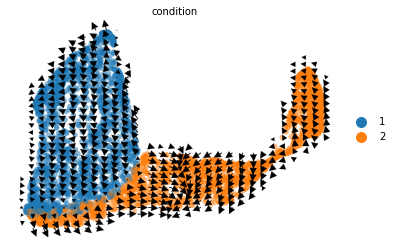

In [33]:
visualization.plot_mean_flow(adata, cluster_key='condition', legend_loc='right')

Exdyn can provide an opptunity to derive the conterfactual estimation of cell state dynamics in a condition different from that where the cells were observed. 
Here, we estimate and display the cell state dynamics of all the cells in condition 1 and 2 respectively.

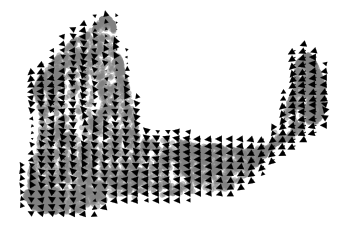

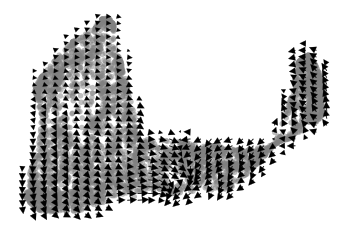

In [34]:
cond1 = '1'
cond2 = '2'
conds = [cond1, cond2]
import importlib;importlib.reload(condiff)
adata = condiff.estimate_two_cond_dynamics(adata, cond1, cond2, lit_envdyn)
for cond in conds:
    visualization.plot_mean_flow(adata, cluster_key=None, legend_loc='right', vel_key=f'norm_cond_vel_{cond}', du_key=f'cond_dumap_{cond}')

We can also visualize the difference between conditions.

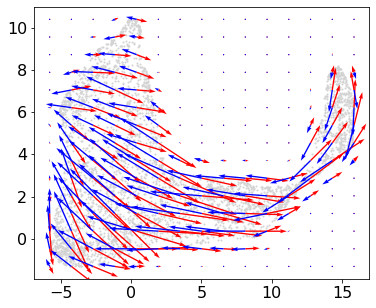

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6 * 1, 5 * 1))
visualization.diff_visualize(adata.obsm['cond_dumap_diff'], adata.obsm['X_umap'], ax)
fig.show()

In general, exdyn can calculate the dynamics across multple conditions more than 2. However, the analysis lacks several two condition specific results.

In [36]:
multi_adata = condiff.estimate_multi_cond_dynamics(adata, [cond1, cond2], lit_envdyn)
print('Two condition version version:')
print(adata)
print('General version:')
print(multi_adata)

Two condition version version:
AnnData object with n_obs × n_vars = 4000 × 100
    obs: 'celltype', 'max_t', 'batch', 'sample', 'condition', 'sl', 'ul', 'vicdyf_fluctuation', 'vicdyf_mean_velocity', 'vicdyf_velocity'
    var: 'mean', 'std', 'dynamics_genes'
    uns: 'condition_colors'
    obsm: 'X_pca', 'X_umap', 'batch', 'condition', 'sample', 'X_vicdyf_z', 'X_vicdyf_zl', 'X_vicdyf_umap', 'X_vicdyf_d', 'X_vicdyf_dl', 'X_vicdyf_sdumap', 'X_vicdyf_mdumap', 'cond_d_1', 'cond_dscale_1', 'cond_dumap_1', 'cond_d_2', 'cond_dscale_2', 'cond_dumap_2', 'cond_d_diff', 'cond_dumap_diff'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'lambda', 'ulambda', 'vicdyf_velocity', 'vicdyf_mean_velocity', 'vicdyf_fluctuation', 'norm_vicdyf_fluctuation', 'norm_vicdyf_mean_velocity', 'norm_vicdyf_velocity', 'cond_vel_1', 'cond_vscale_1', 'cond_vel_2', 'cond_vscale_2', 'norm_cond_vel_1', 'norm_cond_vel_2', 'cond_vel_diff', 'norm_cond_vel_diff'
General version:
AnnData object with n_obs × n_vars = 4000 × 

## Identification analysis of bifurction points between conditions 
Exdyn enables us to identify a bifurcation point between the conditions, where the identical cell states have dynamics varying between the econditions. Here, we extract cells with large conditional difference from the cell population shared by both of the conditions.

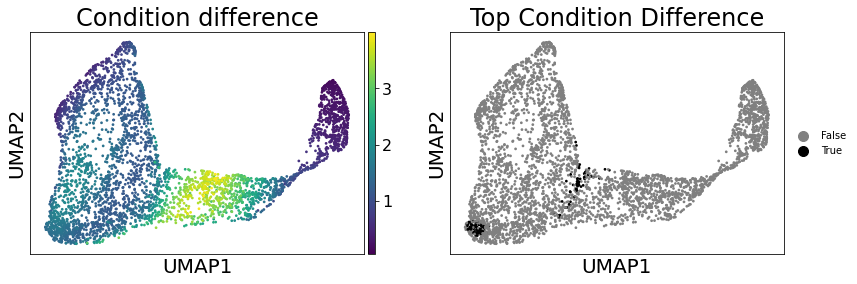

In [37]:
from src import commons
adata.obs['Condition 2 ratio'] = commons.calculate_neighbor_ratio(adata.obsm['X_vicdyf_zl'], adata.obs.condition.values == '2', nn=30)
adata.obs['Condition difference'] = np.linalg.norm(adata.layers['norm_cond_vel_diff'], axis=1)

common_adata = adata[np.logical_and(adata.obs['Condition 2 ratio'] > 0.3, adata.obs['Condition 2 ratio'] < 0.7)]
top_adata = common_adata[common_adata.obs['Condition difference'] > common_adata.obs['Condition difference'].quantile(0.7)]

adata.obs['Top Condition Difference'] = adata.obs_names.isin(top_adata.obs_names).astype(str)
sc.pl.umap(adata, color=['Condition difference', 'Top Condition Difference'], palette={'True': 'black', 'False': 'gray'})

adata.obs['Top Condition Difference'] = adata.obs_names.isin(top_adata.obs_names).astype(str)

We can quantify the gene-wise dynamics difference at the bifurcation point, which leads to the identification of the regulator explaining the population difference between the conditions. Here we calculated the conditional difference and visualize them for top difference genes.

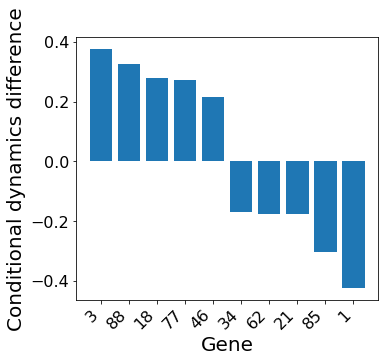

In [38]:
import pandas as pd

cdiff_tot_vels = pd.Series(top_adata.layers[f'norm_cond_vel_diff'].mean(axis=0), index=top_adata.var_names)
top_cdiff_vals = pd.concat([cdiff_tot_vels.sort_values(ascending=False)[:5], cdiff_tot_vels.sort_values(ascending=False)[-5:]])
fig, ax = plt.subplots(1, 1, figsize=(6 * 1, 5 * 1))
visualization.annotated_bars(ax, top_cdiff_vals.index, top_cdiff_vals.values)
ax.set_ylabel('Conditional dynamics difference')
ax.set_xlabel('Gene')
plt.subplots_adjust(bottom=0.15, left=0.2)
fig.show()

You can conduct clustering on the bifurcation point and analyze subpulation if the identified bifurcation points are heterogeneous.

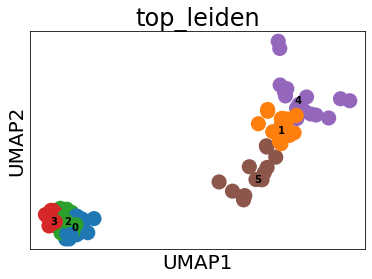

In [40]:
sc.pp.neighbors(top_adata, use_rep='X_vicdyf_zl')
sc.tl.leiden(top_adata, key_added='top_leiden')
adata.obs['top_leiden'] = None
adata.obs.loc[top_adata.obs_names, 'top_leiden'] = top_adata.obs['top_leiden']
sc.pl.umap(top_adata, color='top_leiden', legend_loc='on data')
sub_top_adata = adata[adata.obs.top_leiden.isin(['0', '1'])]


In [41]:
top_adata

AnnData object with n_obs × n_vars = 131 × 100
    obs: 'celltype', 'max_t', 'batch', 'sample', 'condition', 'sl', 'ul', 'vicdyf_fluctuation', 'vicdyf_mean_velocity', 'vicdyf_velocity', 'Condition 2 ratio', 'Condition difference', 'top_leiden'
    var: 'mean', 'std', 'dynamics_genes'
    uns: 'condition_colors', 'neighbors', 'leiden', 'top_leiden_colors'
    obsm: 'X_pca', 'X_umap', 'batch', 'condition', 'sample', 'X_vicdyf_z', 'X_vicdyf_zl', 'X_vicdyf_umap', 'X_vicdyf_d', 'X_vicdyf_dl', 'X_vicdyf_sdumap', 'X_vicdyf_mdumap', 'cond_d_1', 'cond_dscale_1', 'cond_dumap_1', 'cond_d_2', 'cond_dscale_2', 'cond_dumap_2', 'cond_d_diff', 'cond_dumap_diff'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'lambda', 'ulambda', 'vicdyf_velocity', 'vicdyf_mean_velocity', 'vicdyf_fluctuation', 'norm_vicdyf_fluctuation', 'norm_vicdyf_mean_velocity', 'norm_vicdyf_velocity', 'cond_vel_1', 'cond_vscale_1', 'cond_vel_2', 'cond_vscale_2', 'norm_cond_vel_1', 'norm_cond_vel_2', 'cond_vel_diff', 'norm_cond_